In [ ]:

import pandas
import json
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from google.colab import drive, files
from tensorflow import keras

In [ ]:
import tensorflow as tf

def build_model(hp):
  inputs = tf.keras.Input(shape=(32, 32, 3))
  x = inputs
  for i in range(hp.Int('conv_blocks', 3, 5, default=3)):
    filters = hp.Int('filters_' + str(i), 32, 256, step=32)
    for _ in range(2):
      x = tf.keras.layers.Convolution2D(
        filters, kernel_size=(3, 3), padding='same')(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.ReLU()(x)
    if hp.Choice('pooling_' + str(i), ['avg', 'max']) == 'max':
      x = tf.keras.layers.MaxPool2D()(x)
    else:
      x = tf.keras.layers.AvgPool2D()(x)
  x = tf.keras.layers.GlobalAvgPool2D()(x)
  x = tf.keras.layers.Dense(
      hp.Int('hidden_size', 30, 100, step=10, default=50),
      activation='relu')(x)
  x = tf.keras.layers.Dropout(
      hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(x)
  outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

  model = tf.keras.Model(inputs, outputs)
  model.compile(
    optimizer=tf.keras.optimizers.Adam(
      hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
  return model

In [ ]:
pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 5.0MB/s 


In [ ]:
import kerastuner as kt

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    hyperband_iterations=2)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive/MyDrive/Kaggle'

kaggle.json


In [ ]:
with open('/content/drive/My Drive/Kaggle/kaggle.json') as f:
  auth = json.load(f)
  user = auth["username"]
  key = auth["key"]

In [ ]:
os.environ['KAGGLE_USERNAME'] = user
os.environ['KAGGLE_KEY'] = key

In [ ]:
!kaggle datasets download -d drscarlat/melanoma -p '/content/MyDrive/melanoma'

100% 5.25G/5.26G [01:13<00:00, 128MB/s]
100% 5.26G/5.26G [01:13<00:00, 77.0MB/s]


In [ ]:

%cd /content/MyDrive/melanoma

!unzip 'melanoma.zip'


Streaming output truncated to the last 5000 lines.
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031354.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031355.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031357.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031358.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031362.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031363.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031365.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031366.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031367.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031370.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031375.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031380.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031382.jpg  
  inflating: dermmel/DermMel/train_sep/

In [ ]:
!ls '/content/MyDrive/melanoma/DermMel'

test  train_sep  valid


In [ ]:
%cd /content/MyDrive/melanoma/DermMel

/content/MyDrive/melanoma/DermMel


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
minibatch_size = 64
pic_size = 100

data_train = ImageDataGenerator(rescale = 1.0/255.0)
data_valid = ImageDataGenerator(rescale = 1.0/255.0)
data_test = ImageDataGenerator(rescale = 1.0/255.0)

In [ ]:
train_generator = data_train.flow_from_directory('train_sep/', 
                                                 color_mode = 'rgb',
                                                 batch_size = minibatch_size,
                                                 target_size = (pic_size, pic_size),
                                                 class_mode = 'categorical',
                                                 shuffle = True
)

validation_generator = data_valid.flow_from_directory('valid/', 
                                                 color_mode = 'rgb',
                                                 batch_size = minibatch_size,
                                                 target_size = (pic_size, pic_size),
                                                 class_mode = 'categorical',
                                                 shuffle = True
)

test_generator = data_test.flow_from_directory('test/', 
                                                 color_mode = 'rgb',
                                                 batch_size = 1,
                                                 target_size = (pic_size, pic_size),
                                                 class_mode = 'categorical',
                                                 shuffle = True
)

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


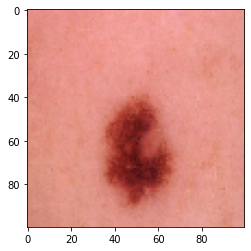

In [ ]:
plt.imshow(train_generator[0][0][9])
plt.show()

In [ ]:
input_shape_dim = train_generator[0][0].shape
input_shape_dim 

(64, 100, 100, 3)

In [ ]:
validation_generator[0][0].shape

(64, 100, 100, 3)

In [ ]:
type(train_generator)

tensorflow.python.keras.preprocessing.image.DirectoryIterator

In [ ]:
out_shape = train_generator[0][1].shape[-1]
out_shape

2

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [ ]:
tuner.search(train_generator,
             validation_data=validation_generator,
             epochs=20,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])


Search: Running Trial #6

Hyperparameter    |Value             |Best Value So Far 
conv_blocks       |4                 |?                 
filters_0         |224               |?                 
pooling_0         |avg               |?                 
filters_1         |192               |?                 
pooling_1         |max               |?                 
filters_2         |160               |?                 
pooling_2         |avg               |?                 
hidden_size       |40                |?                 
dropout           |0                 |?                 
learning_rate     |0.00098182        |?                 
tuner/epochs      |3                 |?                 
tuner/initial_e...|0                 |?                 
tuner/bracket     |2                 |?                 
tuner/round       |0                 |?                 
filters_3         |32                |?                 
pooling_3         |avg               |?                 

Epo

InvalidArgumentError: ignored

In [ ]:
best_model = tuner.get_best_models(1)[0]

In [ ]:
model = tensorflow.keras.Sequential()

In [ ]:
model.add(tensorflow.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape_dim))

In [ ]:
model.add(tensorflow.keras.layers.BatchNormalization())
model.add(tensorflow.keras.layers.MaxPooling2D(pool_size = (2, 2)))
model.add(tensorflow.keras.layers.Dropout(0.3))

model.add(tensorflow.keras.layers.Conv2D(64, (3, 3), activation="relu"))
model.add(tensorflow.keras.layers.BatchNormalization())
model.add(tensorflow.keras.layers.MaxPooling2D(pool_size = (2, 2)))
model.add(tensorflow.keras.layers.Dropout(0.3))

model.add(tensorflow.keras.layers.Conv2D(32, (3, 3), activation="relu"))
model.add(tensorflow.keras.layers.BatchNormalization())
model.add(tensorflow.keras.layers.MaxPooling2D(pool_size = (2, 2)))
model.add(tensorflow.keras.layers.Dropout(0.3))


model.add(tensorflow.keras.layers.Flatten())
model.add(tensorflow.keras.layers.Dense(64, activation="relu"))
model.add(tensorflow.keras.layers.BatchNormalization())
model.add(tensorflow.keras.layers.Dropout(0.3))

model.add(tensorflow.keras.layers.Dense(32, activation="relu"))
model.add(tensorflow.keras.layers.BatchNormalization())
model.add(tensorflow.keras.layers.Dropout(0.25))
model.add(tensorflow.keras.layers.Dense(out_shape, activation ="softmax"))

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
batch_normalization_28 (Batc (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
batch_normalization_29 (Batc (None, 47, 47, 64)        256       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 23, 23, 64)       

In [ ]:
checkpoint = tensorflow.keras.callbacks.ModelCheckpoint("model.h5", 
                                                       monitor = "val_accuracy", 
                                                       verbose = 1, 
                                                       save_best_only = True,
                                                       mode = 'max'
                                                       )
callbacks_list = [checkpoint]

In [ ]:
optimizer = tensorflow.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

In [ ]:
EPOCHS = 15

history = model.fit(train_generator, steps_per_epoch=train_generator.n // train_generator.batch_size, 
                    epochs = EPOCHS, 
                    validation_data = validation_generator, 
                    validation_steps= validation_generator.n //  validation_generator.batch_size,
                    callbacks= callbacks_list)

Epoch 1/15
166/166 [==============================] - 72s 430ms/step - loss: 0.6402 - accuracy: 0.7191 - val_loss: 2.6550 - val_accuracy: 0.4997

Epoch 00001: val_accuracy improved from -inf to 0.49972, saving model to model.h5
Epoch 2/15
166/166 [==============================] - 70s 425ms/step - loss: 0.4182 - accuracy: 0.8125 - val_loss: 0.5970 - val_accuracy: 0.7477

Epoch 00002: val_accuracy improved from 0.49972 to 0.74773, saving model to model.h5
Epoch 3/15
166/166 [==============================] - 71s 427ms/step - loss: 0.3497 - accuracy: 0.8526 - val_loss: 0.6715 - val_accuracy: 0.7710

Epoch 00003: val_accuracy improved from 0.74773 to 0.77102, saving model to model.h5
Epoch 4/15
166/166 [==============================] - 71s 427ms/step - loss: 0.2994 - accuracy: 0.8731 - val_loss: 3.1215 - val_accuracy: 0.5000

Epoch 00004: val_accuracy did not improve from 0.77102
Epoch 5/15
166/166 [==============================] - 71s 427ms/step - loss: 0.2601 - accuracy: 0.8862 - val_

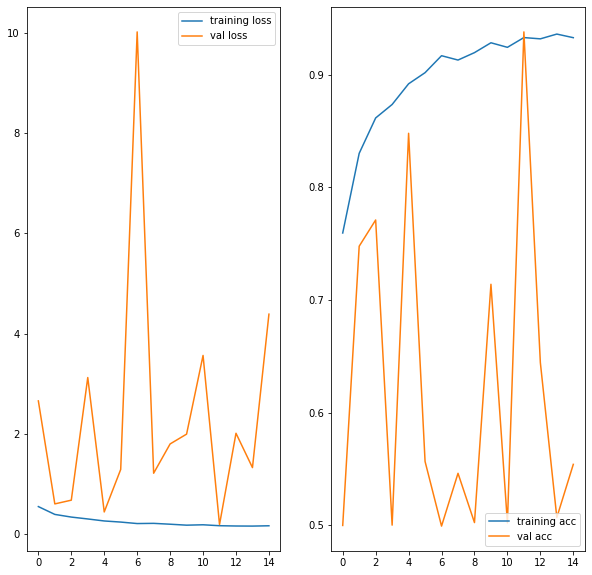

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="training acc")
plt.plot(history.history['val_accuracy'], label="val acc")
plt.legend(loc='upper right')

plt.show()

In [ ]:
files.download("model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.load_weights("model.h5")

In [ ]:
model.evaluate(validation_generator, steps = validation_generator.n //  validation_generator.batch_size )

55/55 [==============================] - 18s 319ms/step - loss: 0.1844 - accuracy: 0.9384


[0.18438178300857544, 0.9383522868156433]

In [ ]:
test_generator.reset()
preds = model.predict(test_generator, steps = test_generator.n//test_generator.batch_size, verbose = 1)

3561/3561 [==============================] - 28s 8ms/step


In [ ]:
model.evaluate(test_generator, steps = test_generator.n//test_generator.batch_size )

3561/3561 [==============================] - 26s 7ms/step - loss: 0.2022 - accuracy: 0.9312


[0.20222525298595428, 0.9311990737915039]